# 1. Install Dependencies and Setup

In [1]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.3.0
altair                       4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asgiref                      3.5.2
astor                        0.8.1
asttokens                    2.0.8
astunparse                   1.6.3
attrs                        22.1.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bio                          1.4.0
biopython                    1.79
biothings-client             0.2.6
bleach                       5.0.1
blinker                      1.5
bokeh                        2.4.3
cachelib                     0.9.0
cachetools                   5.2.0
certifi                      2022.6.15
cffi                         1.15.1
charset-normalizer           2.1.1
click                        7.1.2
clize                        5.0.0
colorama                     0.4.5
commonmark                   0.9.1
contou


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import os
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1320 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()
len('batch')
batch[0].shape

(32, 256, 256, 3)

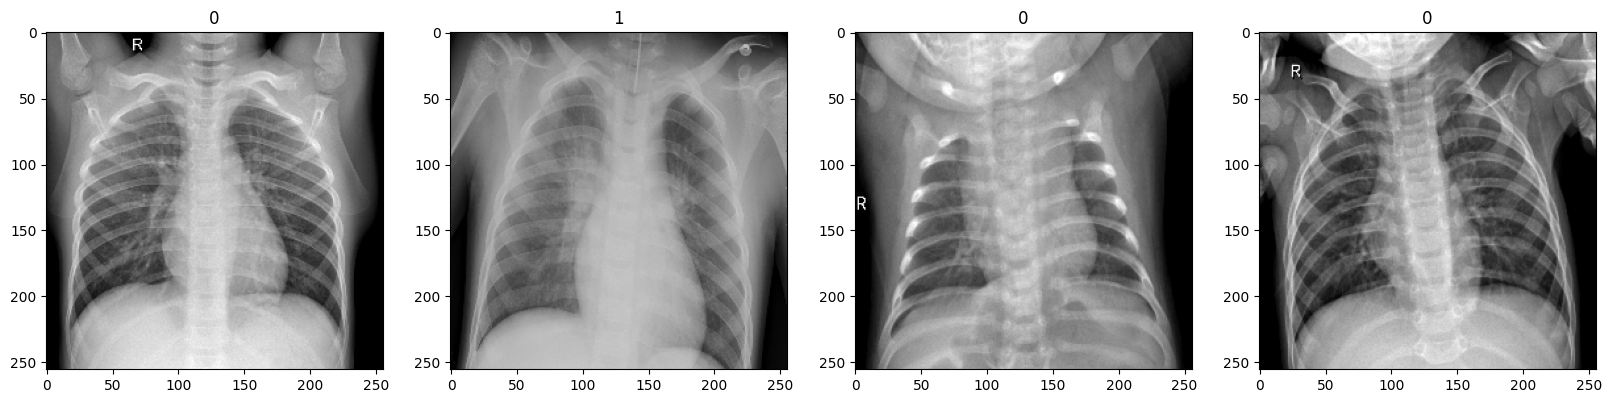

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.36243874, 0.36243874, 0.36243874],
          [0.32435217, 0.32435217, 0.32435217],
          [0.28854167, 0.28854167, 0.28854167]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.33355126, 0.33355126, 0.33355126],
          [0.3507342 , 0.3507342 , 0.3507342 ],
          [0.2765472 , 0.2765472 , 0.2765472 ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.34683993, 0.34683993, 0.34683993],
          [0.36470935, 0.36470935, 0.36470935],
          [0.2953715 , 0.2953715 , 0.2953715 ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

29

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
len('train')

5

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [33]:
model = Sequential()

In [34]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [35]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)      

# 7. Train

In [37]:
logdir='logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
len('data')

4

In [40]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
29/29 [==============================] - 23s 733ms/step - loss: 0.6239 - accuracy: 0.6401 - val_loss: 0.7252 - val_accuracy: 0.6094
Epoch 2/15
29/29 [==============================] - 22s 735ms/step - loss: 0.3854 - accuracy: 0.8556 - val_loss: 0.3029 - val_accuracy: 0.8789
Epoch 3/15
29/29 [==============================] - 22s 739ms/step - loss: 0.2191 - accuracy: 0.9267 - val_loss: 0.2711 - val_accuracy: 0.9180
Epoch 4/15
29/29 [==============================] - 22s 738ms/step - loss: 0.2221 - accuracy: 0.9375 - val_loss: 0.1796 - val_accuracy: 0.9531
Epoch 5/15
29/29 [==============================] - 22s 737ms/step - loss: 0.1673 - accuracy: 0.9547 - val_loss: 0.2176 - val_accuracy: 0.9180
Epoch 6/15
29/29 [==============================] - 22s 742ms/step - loss: 0.1294 - accuracy: 0.9537 - val_loss: 0.1153 - val_accuracy: 0.9648
Epoch 7/15
29/29 [==============================] - 23s 747ms/step - loss: 0.0971 - accuracy: 0.9677 - val_loss: 0.1489 - val_accuracy: 0.9531

# 8. Plot Performance

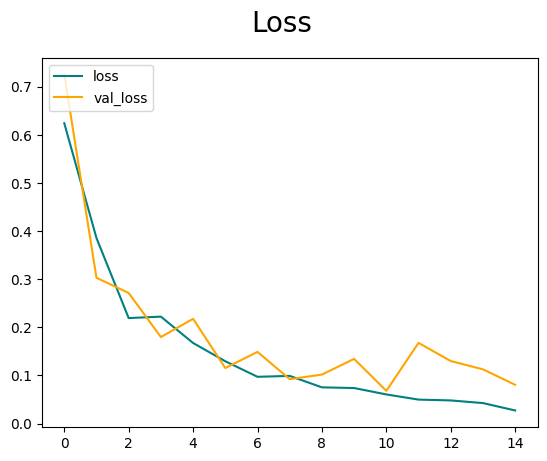

In [41]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

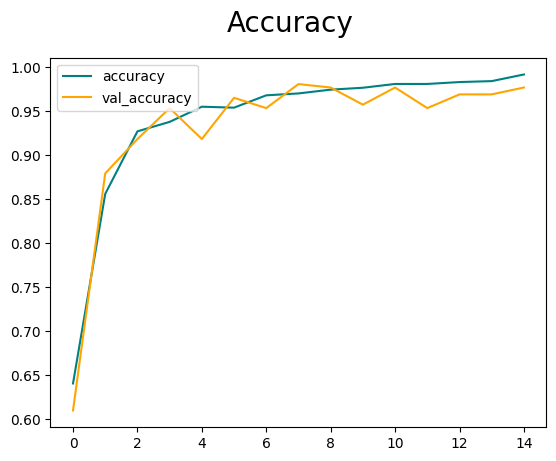

In [42]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [43]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [44]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [45]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 111ms/step


In [46]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9830508, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9921875, shape=(), dtype=float32)


# 10. Test

In [47]:
import cv2

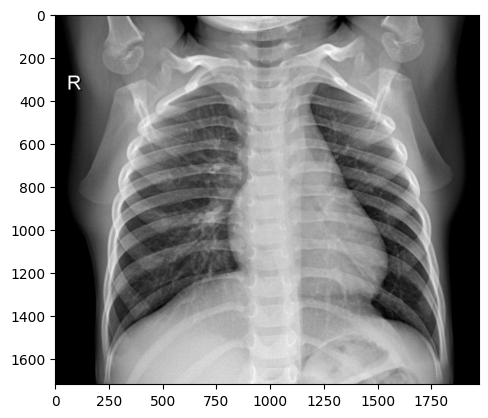

In [48]:
img = cv2.imread('normal.jpeg')
plt.imshow(img)
plt.show()

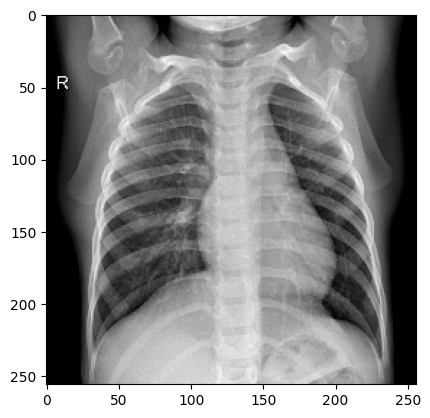

In [49]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [50]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 75ms/step


In [51]:
yhat

array([[1.047609e-06]], dtype=float32)

In [52]:
if yhat > 0.5: 
    print(f'Predicted class is pneumonia')
else:
    print(f'Predicted class is normal')

Predicted class is normal


# 11. Save the Model

In [53]:
from tensorflow.keras.models import load_model

In [54]:
model.save(os.path.join('models','imageclassifier_conv5.h5'))

In [ ]:
#new_model = load_model('C:/Users/ASUS/Desktop/Simha/Machine Intellegence/Project/ImageClassification-main/models/imageclassifierxyz.h5')

In [ ]:
#new_model.predict(np.expand_dims(resize/255, 0))